<a href="https://colab.research.google.com/github/saivardhan4694/cancer-app/blob/main/Lung_Cancer_Detection_CT_HIstopathological.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as op
op.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: makkapatimrk
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


100%|██████████| 1.76G/1.76G [01:25<00:00, 22.2MB/s]


# Lung Cancer Histopathology Image Classification Model

If you enjoyed this notebook and found it helpful, **please give it a like**! Your support is greatly appreciated and motivates us to share more content!

---

## 1. Introduction

This notebook demonstrates the process of building a **convolutional neural network (CNN)** for classifying lung cancer histopathology images using TensorFlow and Keras. The dataset contains various lung tissue images classified into three categories, and we will train a model to distinguish between them. Key highlights include preprocessing techniques, model building, training, and evaluation using visualization techniques.


## 2. Libraries and Environment Setup

We start by importing the necessary libraries. Here's a brief explanation of each:

- `os` and `warnings`: Used to handle system warnings and environment setup, specifically to suppress TensorFlow messages for a cleaner output.
- `numpy`, `matplotlib`, `seaborn`: Essential libraries for numerical operations and data visualization.
- `tensorflow`: The main library for building and training the deep learning model.
- `sklearn.metrics`: Used to generate performance reports such as the **classification report** and **confusion matrix**.
- `kagglehub`: To interact with models saved on KaggleHub.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

# 3. Data Loading and Preprocessing

We load the dataset using the image_dataset_from_directory function, which reads images directly from the directory and creates TensorFlow datasets for training and validation.

Key points:

- The dataset is split into training and validation sets (90% training, 10% validation).
- Images are resized to (32, 32) and normalized by rescaling pixel values.

In [ ]:
path = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

train, val = tf.keras.utils.image_dataset_from_directory(path,
                                                         batch_size = None,
                                                         validation_split = 0.1,
                                                         subset = 'both',
                                                         seed = 6,
                                                         image_size = (32,32))

class_names = train.class_names

Found 15000 files belonging to 3 classes.
Using 13500 files for training.
Using 1500 files for validation.


We apply the rescaling transformation to both training and validation datasets and collect the validation data into arrays x_val and y_val.

In [ ]:
rescale = layers.Rescaling(1/255)

train = train.map(lambda x,y : (rescale(x), y))
val = val.map(lambda x,y : (rescale(x), y))

We apply the rescaling transformation to both training and validation datasets and collect the validation data into arrays x_val and y_val.

In [ ]:
x_val = []
y_val = []

for x, y in val:
    x_val.append(x)
    y_val.append(y.numpy())

x_val = np.array(x_val)
y_val = np.array(y_val)

print(f'  x_val shape : {x_val.shape}\n y_val shape : {y_val.shape}\n')

  x_val shape : (1500, 32, 32, 3)
 y_val shape : (1500,)



### Visualizing Sample Images
We display a few sample images from the training set to understand the data better. Each image is labeled with its corresponding class name.

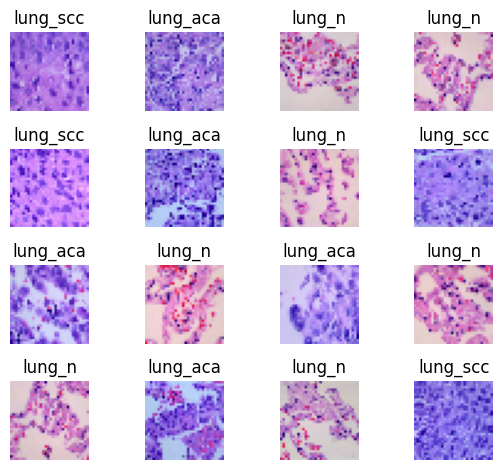

In [ ]:
for idx, (image, label) in enumerate(train.take(16)):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis(False)
    plt.tight_layout()

### One-Hot Encoding of Labels
To make the labels compatible with categorical cross-entropy loss, we one-hot encode the labels and batch the datasets for efficient training. Additionally, we use the prefetch function to optimize data loading.

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def to_categorical_tf(y, num_classes):
    """
    Applies TensorFlow's one_hot to convert labels to categorical format.

    Args:
        y: The labels to convert.
        num_classes: The number of classes.

    Returns:
        The categorical representation of the labels.
    """
    return tf.one_hot(tf.cast(y, tf.int32), num_classes)

train = train.map(lambda x, y: (x, to_categorical_tf(y, num_classes=3))).batch(32).prefetch(tf.data.AUTOTUNE)
val = val.map(lambda x, y: (x, to_categorical_tf(y, num_classes=3))).batch(32).prefetch(tf.data.AUTOTUNE)

# 4. Model Architecture

We define a CNN model using the Sequential API. This architecture includes:
- `Convolutional Layers`: To extract features from images.
- `Batch Normalization`: To normalize the activations and improve training.
- `Dropout`: To prevent overfitting by randomly deactivating neurons.
- `L2 Regularization`: Added to each convolution layer to further reduce overfitting.
- `MaxPooling` : To downsample the feature maps.
- `Dense Layer` with `Softmax Activation' : For multi-class classification output.

In [ ]:
L2=tf.keras.regularizers.l2(0.0001)

model=tf.keras.Sequential([
    layers.Input((32,32,3)),

    layers.Conv2D(64,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),

    layers.Conv2D(64,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),

    layers.Conv2D(128,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(256,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),

#     layers.Conv2D(256,3,activation='relu',padding='same',kernel_regularizer=L2),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),

    layers.Conv2D(256,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

#     layers.Conv2D(512,3,activation='relu',padding='same',kernel_regularizer=L2),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(),

    layers.Conv2D(512,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),

    layers.Conv2D(512,3,activation='relu',padding='same',kernel_regularizer=L2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Flatten(),

    layers.Dense(3,activation='softmax')
           ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,699,203 (17.93 MB)

 Trainable params: 4,695,363 (17.91 MB)

 Non-trainable params: 3,840 (15.00 KB)

# 5. Model Compilation

We compile the model using the Adam optimizer with a learning rate of 0.0001. The loss function is categorical cross-entropy, and the metrics tracked are accuracy and AUC for multi-label classification.

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy',
                         tf.keras.metrics.AUC(multi_label = True)])

# 6. Callbacks

We use three key callbacks to enhance training:

- `EarlyStopping`: Stops training if no improvement is seen for 15 epochs.
- `ReduceLROnPlateau`: Reduces learning rate by half if validation loss plateaus.
- `ModelCheckpoint`: Saves the best model based on validation loss.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15,
                                                  restore_best_weights = True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5,
                                                  patience = 10)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/Lung_Model-{val_loss:.4f}-{val_accuracy:.4f}.keras',
                                                save_best_only = True,
                                                monitor = 'val_loss')

# 7. Model Training

We train the model for 300 epochs and use the callbacks to manage the learning process

In [ ]:
history = model.fit(train,
                    validation_data = val,
                    epochs = 300,
                    callbacks = [early_stopping, lr_plateau, checkpoint])

Epoch 1/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.8026 - auc: 0.9141 - loss: 0.9242 - val_accuracy: 0.3280 - val_auc: 0.5005 - val_loss: 9.2144 - learning_rate: 1.0000e-04
Epoch 2/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8796 - auc: 0.9676 - loss: 0.4805 - val_accuracy: 0.7313 - val_auc: 0.9210 - val_loss: 1.2736 - learning_rate: 1.0000e-04
Epoch 3/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9078 - auc: 0.9794 - loss: 0.3929 - val_accuracy: 0.5400 - val_auc: 0.7894 - val_loss: 2.7295 - learning_rate: 1.0000e-04
Epoch 4/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9259 - auc: 0.9854 - loss: 0.3483 - val_accuracy: 0.5560 - val_auc: 0.7795 - val_loss: 3.1096 - learning_rate: 1.0000e-04
Epoch 5/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9372 - auc: 0.9884 - loss: 0.3238 - val_accuracy: 0.7347 - val_auc: 0.8903 - val_loss: 1.7891 - learning_rate: 1.0000e-04
Epoch 6/300
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/

# 8. Evaluation and Visualization

- `Accuracy and Loss Curves`
We plot the training and validation accuracy and loss over epochs to visualize model performance.

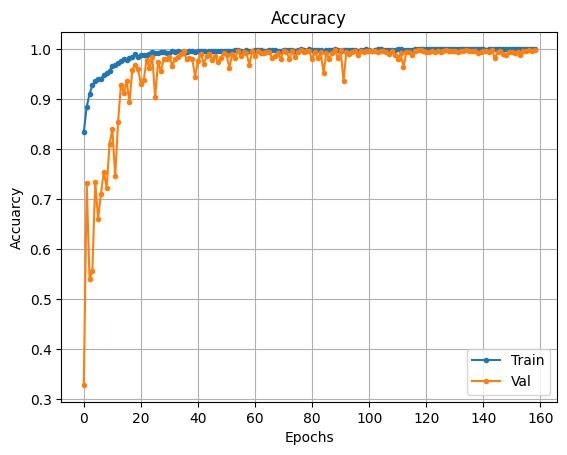

In [ ]:
plt.plot(history.history['accuracy'], marker = '.')
plt.plot(history.history['val_accuracy'], marker = '.' )
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend(['Train','Val'])
plt.grid()
plt.show()

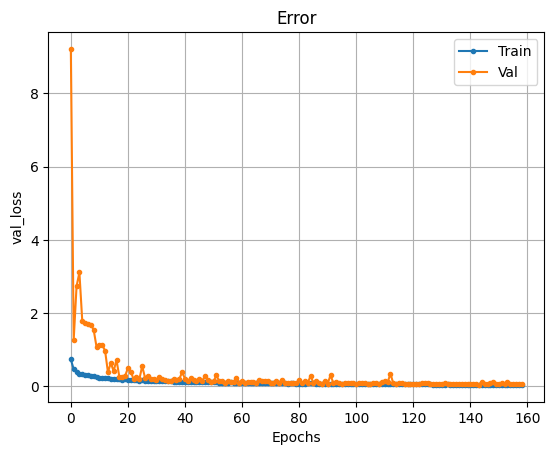

In [ ]:
plt.plot(history.history['loss'], marker = '.')
plt.plot(history.history['val_loss'], marker = '.' )
plt.title('Error')
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend(['Train','Val'])
plt.grid()
plt.show()

In [ ]:
model.save('Lung_Model.h5')

In [ ]:
lung_model = tf.keras.models.load_model('/content/Lung_Model.h5')

In [ ]:
pred = lung_model.predict(x_val)
y_pred = np.argmax(pred, axis = 1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


# Classification_Report and Confusion Matrix
Finally, we load the best model, make predictions, and generate the classification report and confusion matrix for the validation data.

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       493
           1       1.00      1.00      1.00       515
           2       0.99      1.00      1.00       492

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



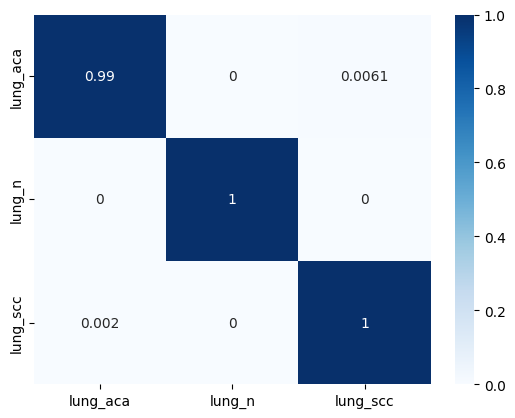

In [ ]:
sns.heatmap(confusion_matrix(y_val, y_pred, normalize = 'true'),
            annot = True,
            cmap = 'Blues',
            xticklabels = class_names,
            yticklabels = class_names)
plt.show()